<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N_0606c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 123.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=57a03c0f898f9852f817bb5ee578af099639bf865ab95207f906ef859856a0ec
  Stored in directory

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

from PIL import Image


In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3, data_transforms4

from model_container import ModelContainer



Mounted at /content/gdrive


# Create Datasets and DataLoaders

In [6]:

#create the datasets
#train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



Creating an alternative dataframe where the val images are randomly chosen rather than the midpoint as originally performed. Also, creating a larger train dataset to explore. 

In [7]:
# val_ran_df = create_dataset(val_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior = 'random', a=0.1, b=0.9)
# train_large_df = create_dataset(train_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior='range', a=0.1, b=0.9)

# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')
# train_large_df.to_pickle('/content_grdive/MyDrive/train_large_df.pkl')

In [8]:
# val_ran_df
# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [9]:
# have already pickled the datasets and just loading here
train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')
val_ran_df = pd.read_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [10]:
# Get the data loaders
# dataloaders - vanilla, no augmentation just cropping and resizing, number channels to 1, and to tensor
# dataloaders2 - some augmentation (color jitter)
# dataloaders3 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 2 to highlight bright pixels
# dataloaders4 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 0.5 for comparison

batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
train_loader4, val_loader4, test_loader4, dataset_sizes4 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms4)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}
dataloaders4 = {'train': train_loader4, 'val': val_loader4, 'test': test_loader4}


# Explore Base Model Archictectures#

Comparing the accuracy of various models on the validation dataset. There are two variations of the ResNet50 model, the first (CustomResNet) with a single fully connected layer as the head and the second (CustomResNetb) with two fully connected layers separated by ReLU. There is also a DenseNet model with a single fully connected layer as the head. Both SGD and Adam optimizers are used for each combination, as are Cross Entropy Loss and a custom Focal Loss. 

For data preparation, there are four different combinations: a vanilla transformer that only uses cropping and resizing, transformer2 which also uses some augmentation (color jitter), and transformers 3 and 4 which use a gamma function to alter the image (presumably to highlight bright pixels) with two different settings for comparison (although will likely perform the last comparison only on the 'best model' from the other comparisons. 

In [11]:
# Different combinations to evaluate
models = [CustomDenseNet]
loss_funcs = [FocalLoss] 
loaders = ['dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3, 'dataloaders4': dataloaders4}
optimizers = ['Adam']
optim_dict = {

    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomDenseNet, dataloaders2, Adam, FocalLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 139MB/s]


Epoch 0/14
----------
train Loss: 1.0069 Acc: 0.5500
val Loss: 1.6819 Acc: 0.5226

Epoch 1/14
----------
train Loss: 0.6504 Acc: 0.6881
val Loss: 0.9144 Acc: 0.5508

Epoch 2/14
----------
train Loss: 0.4168 Acc: 0.7626
val Loss: 0.6026 Acc: 0.6949

Epoch 3/14
----------
train Loss: 0.3731 Acc: 0.7852
val Loss: 0.8284 Acc: 0.6554

Epoch 4/14
----------
train Loss: 0.3368 Acc: 0.7940
val Loss: 0.7344 Acc: 0.6667

Epoch 5/14
----------
train Loss: 0.2838 Acc: 0.8276
val Loss: 0.6787 Acc: 0.6836

Epoch 6/14
----------
train Loss: 0.2248 Acc: 0.8524
val Loss: 0.6553 Acc: 0.6836

Epoch 7/14
----------
train Loss: 0.1170 Acc: 0.9189
val Loss: 0.3593 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0600 Acc: 0.9540
val Loss: 0.3200 Acc: 0.8164

Epoch 9/14
----------
train Loss: 0.0501 Acc: 0.9642
val Loss: 0.3421 Acc: 0.8277

Epoch 10/14
----------
train Loss: 0.0413 Acc: 0.9649
val Loss: 0.3269 Acc: 0.8333

Epoch 11/14
----------
train Loss: 0.0368 Acc: 0.9693
val Loss: 0.3361 Acc: 0.8390

Ep

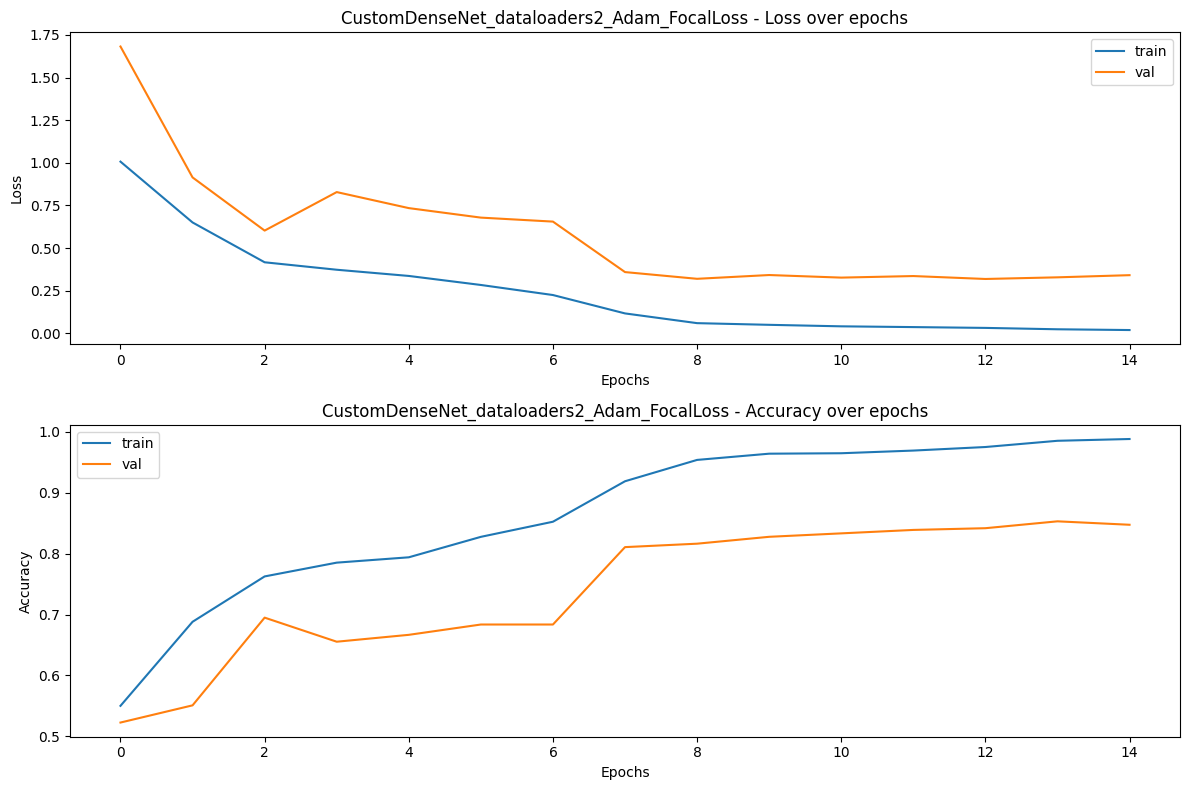

In [12]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy
               

In [13]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.83      0.80      0.81        49
           6       0.88      1.00      0.93        14
           7       0.94      0.94      0.94        18
           8       0.97      0.94      0.96        35
           9       0.97      0.97      0.97        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.86      1.00      0.93        19
          16       0.41      0.70      0.52        20
          17       0.94      0.94      0.94        17
          18       0.95      0.95      0.95        22
          19       1.00      0.95      0.97        19
          23       0.39      0.37      0.38        19
          25       0.92   

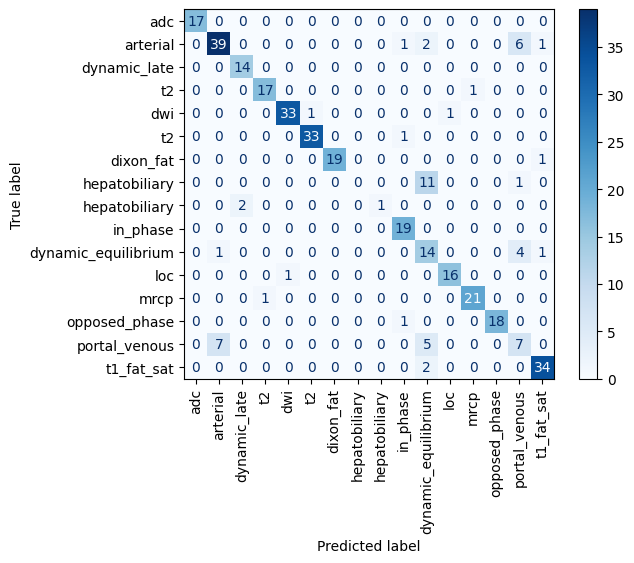

<Figure size 2500x2500 with 0 Axes>

In [14]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


save_filename = f"cnn_model_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_predictions, val_labels, classes, fn=save_filename, saveflag=True)

# Save the trained model if needed

torch.save(trained_model.state_dict(), f'/content/gdrive/MyDrive/{save_filename}')




In [15]:
best_combo

'CustomDenseNet_dataloaders2_Adam_FocalLoss'

#Experiment: gamma filter with different hyperparameter#
Looking at applying a gamma filter on the images with two different settings to see if it affects accuracy. One of the key components that a human looks at is the distribution of bright pixels (and how they correspond to different portions of anatomy), so a gamma filter may affect how bright pixels are accentuated in the image. 


Training with CustomDenseNet, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.1387 Acc: 0.5091
val Loss: 0.9928 Acc: 0.5537

Epoch 1/14
----------
train Loss: 0.5948 Acc: 0.6917
val Loss: 0.7269 Acc: 0.6328

Epoch 2/14
----------
train Loss: 0.4265 Acc: 0.7750
val Loss: 0.8000 Acc: 0.6299

Epoch 3/14
----------
train Loss: 0.4039 Acc: 0.7589
val Loss: 0.9332 Acc: 0.6045

Epoch 4/14
----------
train Loss: 0.3416 Acc: 0.7933
val Loss: 0.5289 Acc: 0.7627

Epoch 5/14
----------
train Loss: 0.2743 Acc: 0.8218
val Loss: 0.5655 Acc: 0.7232

Epoch 6/14
----------
train Loss: 0.2290 Acc: 0.8459
val Loss: 0.7274 Acc: 0.7260

Epoch 7/14
----------
train Loss: 0.1146 Acc: 0.9211
val Loss: 0.3947 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.0551 Acc: 0.9584
val Loss: 0.3779 Acc: 0.8418

Epoch 9/14
----------
train Loss: 0.0420 Acc: 0.9664
val Loss: 0.3699 Acc: 0.8475

Epoch 10/14
----------
train Loss: 0.0470 Acc: 0.9613
val Loss: 0.3398 Acc: 0.8418

Epoch 11/14
----------
tr

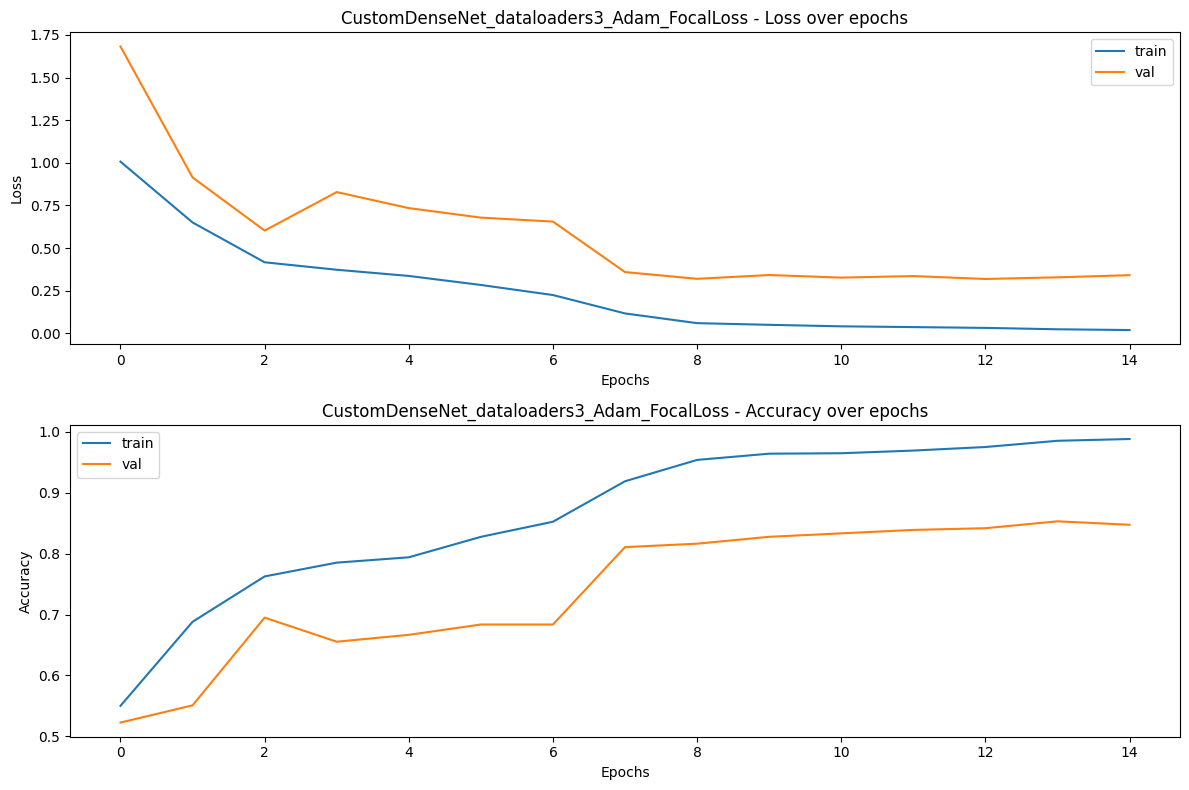


Training with CustomDenseNet, dataloaders4, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0644 Acc: 0.5347
val Loss: 1.2181 Acc: 0.4802

Epoch 1/14
----------
train Loss: 0.6743 Acc: 0.6764
val Loss: 1.0964 Acc: 0.5480

Epoch 2/14
----------
train Loss: 0.4588 Acc: 0.7451
val Loss: 0.8239 Acc: 0.6836

Epoch 3/14
----------
train Loss: 0.3456 Acc: 0.7933
val Loss: 0.8248 Acc: 0.5932

Epoch 4/14
----------
train Loss: 0.2951 Acc: 0.8174
val Loss: 0.6422 Acc: 0.7034

Epoch 5/14
----------
train Loss: 0.2714 Acc: 0.8247
val Loss: 0.4185 Acc: 0.7910

Epoch 6/14
----------
train Loss: 0.2200 Acc: 0.8495
val Loss: 0.8658 Acc: 0.6186

Epoch 7/14
----------
train Loss: 0.1278 Acc: 0.9116
val Loss: 0.3107 Acc: 0.8503

Epoch 8/14
----------
train Loss: 0.0693 Acc: 0.9474
val Loss: 0.3096 Acc: 0.8503

Epoch 9/14
----------
train Loss: 0.0509 Acc: 0.9635
val Loss: 0.2962 Acc: 0.8588

Epoch 10/14
----------
train Loss: 0.0445 Acc: 0.9642
val Loss: 0.2919 Acc: 0.8701

Epoch 11/14
----------
tr

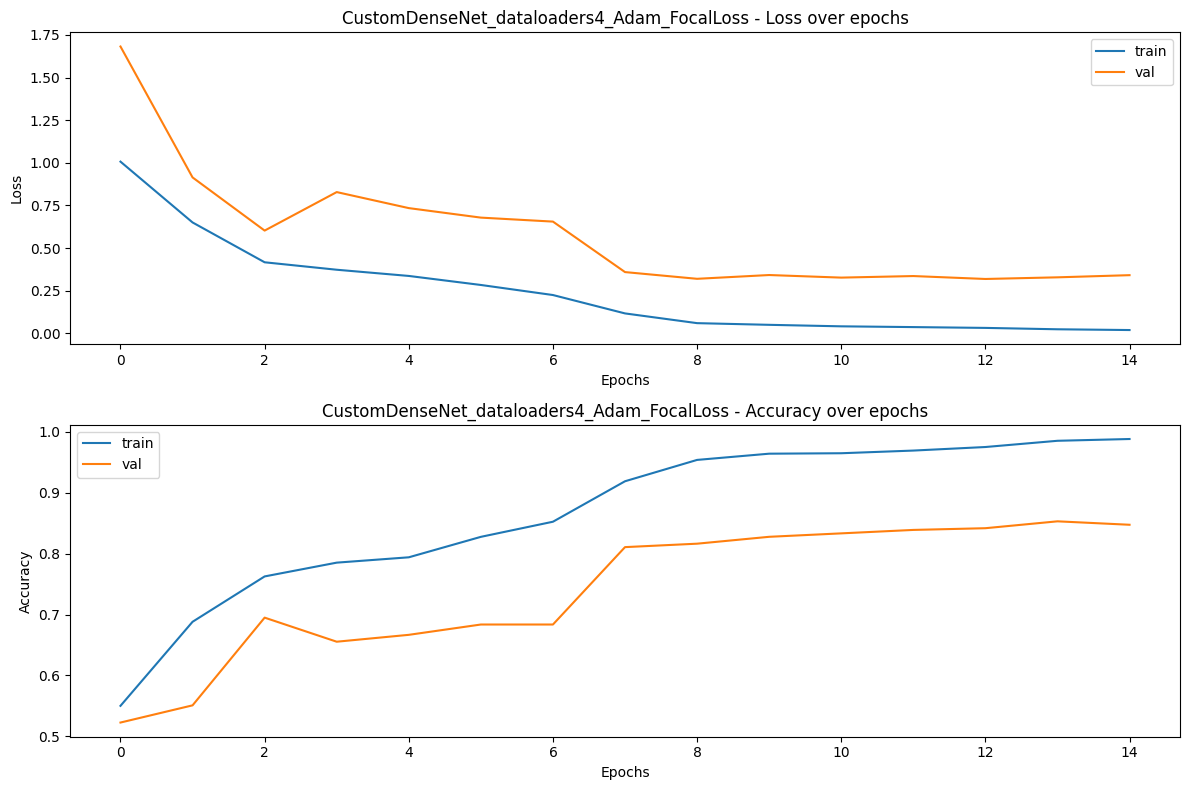

In [16]:
# perform several training runs to compare accuracy on the validation dataset


models_g = [CustomDenseNet]
loss_funcs_g = [FocalLoss] 
loaders_g = ['dataloaders3', 'dataloaders4']
optimizers_g = ['Adam']

best_model_g = None
best_accuracy_g = -1

for model_class in models_g:
  for loader in loaders_g:
        for opt in optimizers_g:
            for loss_func_class in loss_funcs_g:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model_g, best_val_accuracy_g, history_g = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history_g['train_loss'])
                print("Validation loss history:", history_g['val_loss'])
                print("Training accuracy history:", history_g['train_acc'])
                print("Validation accuracy history:", history_g['val_acc'])


                # Plot training curves
                combination_name_g = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name_g)

                if best_val_accuracy_g > best_accuracy_g:
                  best_model_g = trained_model_g
                  best_combo_g = combination_name_g
                  best_accuracy_g = best_val_accuracy_g
               


#Experiment: Same slice versus different random slice on inference#
Comparing the results with the validation dataset using the same 'center slice' method as for the training data, versus using a random image from each series as the alternative validation dataset. 

In [17]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/model0530a.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.66      0.84      0.74        49
           6       0.83      0.71      0.77        14
           7       0.93      0.72      0.81        18
           8       0.85      0.97      0.91        35
           9       0.90      0.76      0.83        34
          11       0.61      0.70      0.65        20
          12       0.50      0.08      0.14        12
          13       1.00      0.33      0.50         3
          14       0.88      0.74      0.80        19
          16       0.47      0.35      0.40        20
          17       0.57      0.71      0.63        17
          18       0.88      0.95      0.91        22
          19       0.77      0.89      0.83        19
          23       0.50      0.11      0.17        19
          25       0.56   

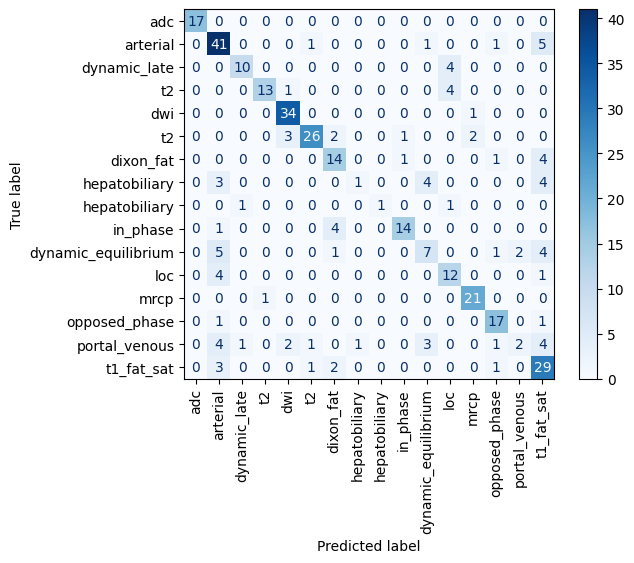

<Figure size 2500x2500 with 0 Axes>

In [18]:
# Evaluate the model on the random val dataset


model.eval()
val_ran_predictions = []
val_ran_labels = []
_, val_ran_loader, _, _ = get_data_loaders(train_df, val_ran_df, test_df, batch_size, data_transforms=data_transforms2)

for inputs, labels in val_ran_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_ran_predictions.append(predicted.cpu().numpy())
        val_ran_labels.append(labels.cpu().numpy())
val_ran_predictions = np.concatenate(val_ran_predictions, axis=0)
val_ran_labels = np.concatenate(val_ran_labels, axis=0)


save_filename = f"cnn_model_randomval_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_ran_predictions, val_ran_labels, classes, fn=save_filename, saveflag=True)




Much lower accuracy when the validation images are randomly selected but the train images are all the midpoint images. Will have to see if training over random train images or the full set of train images will help this. In the meantime, for any inference would select the midpoint images to match what the model was trained on. 

#Experiment: Focal Loss with different alpha values for each class# 
Introducing a new custom loss function (FocalLoss2) which accepts a dictionary of values for the alpha to specify the degree of emphasis for each class. This may negatively impact the overall accuracy, however. 

In [29]:
import torch.nn.functional as F

class FocalLoss2(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')

        if self.alpha is not None:
            alpha_weights = torch.ones_like(CE_loss)
            alpha_weights *= self.alpha  # Initialize weights with alpha for all classes

            for cls, weight in self.alpha.items():
                alpha_weights[targets == cls] = weight  # Update weights for specified classes

            CE_loss *= alpha_weights

        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)



class FocalLoss3(nn.Module):
    def __init__(self, alpha_list, gamma=2, reduction='mean'):
        super(FocalLoss3, self).__init__()
        self.alpha_list = torch.tensor(list(alpha_list.values()), dtype=torch.float32)  # Convert values to a list
        self.gamma = gamma
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        device = inputs.device 
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        alpha_weights = torch.tensor(self.alpha_list)[targets.to(device)].to(device)
        focal_loss = (alpha_weights * (1 - pt) ** self.gamma * ce_loss).mean()

        return focal_loss


In [30]:
alpha_list = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1}
f_loss_fn = FocalLoss3(alpha_list = alpha_list, gamma=2)


In [31]:
device

device(type='cuda')

In [32]:
train_f_loader, val_f_loader, test_f_loader, size = get_data_loaders(train_df, val_df, test_df, batch_size=8, data_transforms=data_transforms2)
dataloaders_f = {'train': train_f_loader, 'val': val_f_loader, 'test': test_f_loader}

In [33]:
# perform focal loss experiment on the validation dataset
# Evaluate the model on the test dataset
#model = loaded_model.to(device)
models = [CustomDenseNet]
loaders = ['dataloaders2']
optimizers = ['Adam']
loss_funcs = [f_loss_fn, FocalLoss]

best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class}, {loader}, {opt}, {loss_func_class}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Instantiate the selected loss function
                criterion = loss_func_class

                
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy
               


Training with <class 'cnn.cnn_model.CustomDenseNet'>, dataloaders2, Adam, FocalLoss3()
Epoch 0/14
----------


OutOfMemoryError: ignored

# Attempt at using Vision Transformers#

In [34]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata_deit = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata_deit = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata_deit = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader_deit = DataLoader(train_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader_deit = DataLoader(val_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader_deit = DataLoader(test_imgdata_deit, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes_deit = {'train': len(train_imgdata_deit), 'val': len(val_imgdata_deit)}

    return train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit



train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.weight', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream t

In [60]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [80]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = criterion.to(device)
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = epoch_acc.item() 


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best val Acc: {best_acc:4f}')


    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history




Epoch 0/24
----------
train Loss: 2.8869 Acc: 0.1351
val Loss: 2.4056 Acc: 0.1836

Epoch 1/24
----------
train Loss: 2.2849 Acc: 0.2345
val Loss: 2.2050 Acc: 0.2627

Epoch 2/24
----------
train Loss: 2.0762 Acc: 0.2841
val Loss: 2.2381 Acc: 0.1977

Epoch 3/24
----------
train Loss: 2.0431 Acc: 0.3141
val Loss: 2.2576 Acc: 0.3220

Epoch 4/24
----------
train Loss: 1.9058 Acc: 0.3492
val Loss: 2.0839 Acc: 0.3277

Epoch 5/24
----------
train Loss: 1.8461 Acc: 0.3740
val Loss: 2.0560 Acc: 0.3475

Epoch 6/24
----------
train Loss: 1.8027 Acc: 0.3791
val Loss: 2.1076 Acc: 0.3079

Epoch 7/24
----------
train Loss: 1.7845 Acc: 0.3791
val Loss: 1.9744 Acc: 0.3475

Epoch 8/24
----------
train Loss: 1.6071 Acc: 0.4405
val Loss: 1.9419 Acc: 0.4011

Epoch 9/24
----------
train Loss: 1.5214 Acc: 0.4609
val Loss: 1.8910 Acc: 0.3701

Epoch 10/24
----------
train Loss: 1.5037 Acc: 0.4690
val Loss: 1.9246 Acc: 0.3446

Epoch 11/24
----------
train Loss: 1.4925 Acc: 0.4777
val Loss: 1.7716 Acc: 0.3927

Ep

AttributeError: ignored

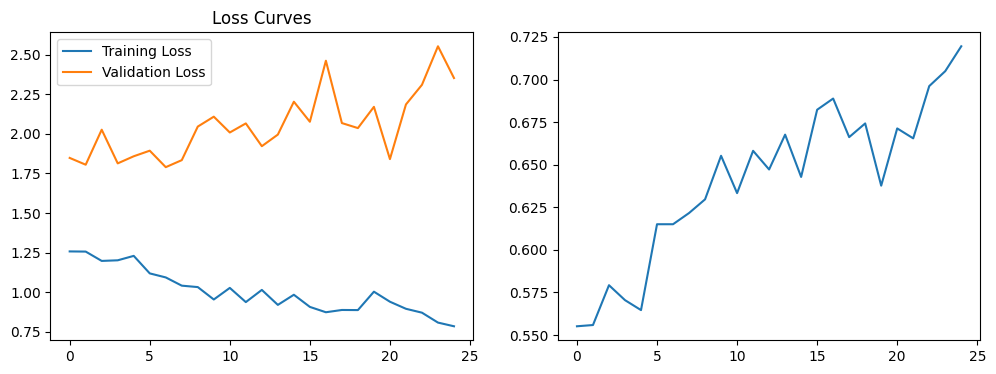

In [81]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
deit_model = deit_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters())

dataloaders = {'train': train_loader_deit, 'val': val_loader_deit}

deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, dataloaders, criterion, optimizer, num_epochs=25)

deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load pre-trained DeiT model and adjust the classifier for your number of classes
# deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# num_classes = len(classes) # classes is your list of classes
# deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# deit_model.to(device)

# # Define your loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

# num_epochs = 20

# # Start training
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader_deit, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = deit_model(inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0


#Evaluating the best model on the test dataset


In [ ]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/model0530a.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)







In [ ]:
test_df['predictions'] = [classes[x] for x in test_predictions]
incorrect_df = test_df.copy()
incorrect_df = incorrect_df[incorrect_df.predictions!=incorrect_df.label]
incorrect_df = incorrect_df.reset_index()
incorrect_df.to_pickle('/content/gdrive/MyDrive/incorrect_df0604a.pkl')
test_df.to_pickle('/content/gdrive/MyDrive/test_with_preds0604a.pkl')

In [ ]:
class ImgDatasetForVis(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img_file = self.data_df.fname[idx]
        ds = pydicom.dcmread(img_file)
        img = np.array(ds.pixel_array, dtype=np.float32)
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        if self.transform: 
          img = self.transform(img)
        
        
        labl = self.data_df.label[idx]
        adjusted_label = classes.index(labl)
        y = torch.tensor(adjusted_label, dtype=torch.long)
        
        return img, y, img_file  # also return file path


# Create a data loader for visualization
vis_dataset = ImgDatasetForVis(test_df, data_transforms['test'])  
vis_loader = DataLoader(vis_dataset, batch_size=batch_size, shuffle=False)
incorrect_dataset= ImgDatasetForVis(incorrect_df, data_transforms['test'])
incorrect_loader = DataLoader(incorrect_dataset, batch_size=batch_size, shuffle=False)



In [ ]:

def visualize_results2(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels, filenames = next(iter(dataloader))
        print(filenames)
        #original_images = images.clone() # Store a copy of original images
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 20))
    grid_size = 4
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(grid_size, grid_size, idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(classes[preds[idx]])]['short'], abd_label_dict[str(classes[labels[idx]])]['short']),
            color=("green" if preds[idx]==labels[idx] else "red"))

    return

In [ ]:
# Now use 'vis_loader' in your visualization function
visualize_results2(best_model, vis_loader, device)

In [ ]:
## show incorrect predictions

def visualize_incorrect(df):
   
    # Get a batch of validation images
    filenames = df.fname
    preds = df.predictions 
    labels = df.label
        
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(50, 50))
    grid_size = 4
    fontsize = 24

    for idx, row in df.iterrows():
        #print(idx)
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

       
        #ax = fig.add_subplot(grid_size, int(len(preds)/grid_size), idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
            color=("green" if pred==label else "red"), font_size=font_size)

    return

In [ ]:


def visualize_incorrect2(df):
    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Set plot parameters for publication quality
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 14
    plt.rcParams['lines.linewidth'] = 2

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure()
    grid_size = 4

    for idx, row in df.iterrows():
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

        ds = pydicom.dcmread(filename)
        image = ds.pixel_array

        # Apply center crop
        image = center_crop(image)

        # Increase brightness
        image = image * 1.5

        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
                     color=("green" if pred==label else "red"))

        # Remove the axis labels
        ax.axis('off')

    plt.tight_layout()

    # Save the plot as a high-resolution image
    plt.savefig('publication-quality-plot_incorrect.png', dpi=300)

    plt.show()



In [ ]:
visualize_incorrect2(incorrect_df[:16])

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

def visualize_grad_cam(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0)  # Add batch dimension
    image.requires_grad = True

    # Forward pass
    output = model(image)
    _, predicted_class = torch.max(output, 1)

    # Compute gradients
    model.zero_grad()
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0, target_class] = 1
    output.backward(gradient=one_hot_output)

    # Get the gradients of the last convolutional layer
    gradients = model.get_activations_gradient()

    # Pool the gradients across channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Get the activations of the last convolutional layer
    activations = model.get_activations(image).detach()

    # Weight the activations by the gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the weighted activations along the channels dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    # Resize the heatmap to match the image size
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(image.size(2), image.size(3)), mode="bilinear", align_corners=False)
    heatmap = heatmap.squeeze().numpy()

    # Plot the heatmap and the original image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.squeeze().permute(1, 2, 0))
    ax1.axis('off')
    ax1.set_title('Original Image')
    ax2.imshow(image.squeeze().permute(1, 2, 0))
    ax2.imshow(heatmap, alpha=0.5, cmap='jet')
    ax2.axis('off')
    ax2.set_title('Grad-CAM Heatmap')
    plt.tight_layout()
    plt.show()

# Usage:
model = YourModel()  # Replace with your own model
image = ...  # Load or generate the input image
target_class = 0  # Specify the target class for visualization
visualize_grad_cam(model, image, target_class)
